# Exemplo 01 - Classificação de Imagens com MLP
## Curso de Deep Learning

## Instalações e imports

In [1]:
%%capture
!pip install torchsummary

In [2]:
# modelagem e dados
import torch
from torchvision import transforms, datasets
from torch import nn, optim
from torch.utils import data


# avaliação de modelos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Dataset e DataLoaders

O PyTorch possui duas principais unidades na utilização de base de dados:
- Dataset: Agrupa os dados, guardando informações e contendo funções para carregamento de instâncias
- DataLoader: Cria um iterador que carrega os dados em lotes (batch) estruturados além de ser responsável por (opcionalmente) randomizar a ordem de carregamento

A dataset utilizada para esse exemplo é MNIST: um "Hello, world!" para redes neurais caracterizando um problema de classificação de imagens de dígitos em preto e branco. São 70000 imagens no total com formato 28x28 pixels.

In [3]:
# As imagens são carregadas internamente com uma biblioteca de processamento de
# imagens e precisam ser convertidas para um formato apropriado (ToTensor)
transform = transforms.ToTensor()

In [4]:
print(datasets.MNIST.__doc__)

`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``MNIST/raw/train-images-idx3-ubyte``
            and  ``MNIST/raw/t10k-images-idx3-ubyte`` exist.
        train (bool, optional): If True, creates dataset from ``train-images-idx3-ubyte``,
            otherwise from ``t10k-images-idx3-ubyte``.
        download (bool, optional): If True, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    


In [5]:
train_ds = datasets.MNIST(
    root = ".",
    train = True,
    download = True,
    transform = transform
)

# Criar um conjunto de validação a partir de um subconjunto aleatório
# com 15% dos dados de treino originais
length = len(train_ds)
len_val = int(0.15 * length)
len_train = length - len_val
train_ds, val_ds = data.random_split(train_ds, [len_train, len_val])

test_ds = datasets.MNIST(
    root = ".",
    train = False,
    download = True,
    transform = transform
)

100%|██████████| 9912422/9912422 [00:00<00:00, 82034279.67it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 89135904.21it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 75590121.50it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19844300.80it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Determinar tamanhos dos lotes

In [6]:
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_EVAL = 128

Criação dos dataloaders

In [7]:
train_dl = data.DataLoader(
    train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True,
    num_workers=2, pin_memory=True
)

val_dl = data.DataLoader(
    val_ds, batch_size=BATCH_SIZE_EVAL, shuffle=True,
    num_workers=2, pin_memory=True
)

test_dl = data.DataLoader(
    test_ds, batch_size=BATCH_SIZE_EVAL, shuffle=True,
    num_workers=2, pin_memory=True
)

### Visualizando a base de dados

In [8]:
instances, targets = next(iter(test_dl))

In [9]:
instances.shape, targets.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

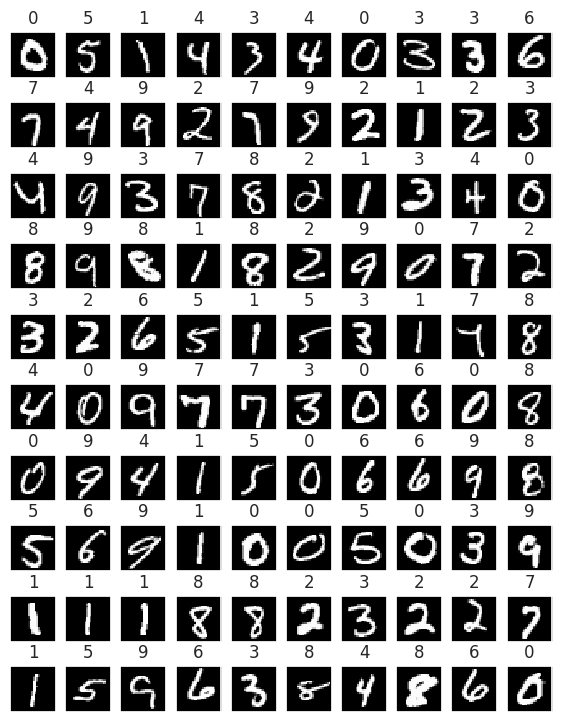

In [10]:
w = 10
fig, ax = plt.subplots(w, w, figsize=(7, 9))
for i in range(w):
  for j in range(w):
    ax[i][j].imshow(instances[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
    label = targets[i * w + j].item()
    ax[i][j].set_title(label)
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

## Criação de modelo

Em PyTorch, modelos são normalmente criados utilizando herança da classe ```torch.nn.Module``` com as camadas disponíveis para utilização também estando disponíveis primariamente através do módulo ```torch.nn```.

Na primeira camada precisamos transformas as imagens do formato 1x28x28 para vetores de tamanho 28*28 (ou seja, 784). Para isso, utilizamos a classe Flatten.

Após isso, utilizamos objetos do tipo nn.Linear para criar as camadas do MLP. Você pode criar variáveis internas separadas para cada camada ou utilizar a classe Sequential para agrupar sequecialmente as camadas. Devemos lembrar de adicionar funções de ativação entre cada Linear (aqui utilizaremos a função ReLU).

A função de ativação para a saída (no caso da classificação com mais de 2 classes, Softmax) é opcional nesse caso. A função de perda a ser utilizada já possui a aplicação de tal ativação embutida.

---

Extraído da docstring da classe Linear:

Argumentos:
- in_features: size of each input sample
- out_features: size of each output sample
- bias: If set to ``False``, the layer will not learn an additive bias.      Default: ``True``

Formato:
- Input: $(*, H_{in})$ where $*$ means any number of
  dimensions including none and $H_{in} = \text{in_features}$.
- Output: $(*, H_{out})$ where all but the last dimension
  are the same shape as the input and $H_{out} = \text{out_features}$.

Atributos:
- weight: the learnable weights of the module of shape
   $(\text{out_features}, \text{in_features})$. The values are
   initialized from $\mathcal{U}(-\sqrt{k}, \sqrt{k})$, where
$k = \frac{1}{\text{in_features}}$
- bias:   the learnable bias of the module of shape $(\text{out_features})$.
   If `bias` is ``True``, the values are initialized from
   $\mathcal{U}(-\sqrt{k}, \sqrt{k})$ where $k = \frac{1}{\text{in_features}}$



In [11]:
class MyFirstModel(nn.Module):
  def __init__(self, n_classes):
    super().__init__() # necessário sempre

    self.flatten = nn.Flatten()

    self.mlp = nn.Sequential(
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  # Esse método é necessário. Executada o passo feed-forward da computação da
  # rede neural.
  def forward(self, x):
    x_flat = self.flatten(x)
    logits = self.mlp(x_flat)
    return logits

Testando

In [12]:
test_model = MyFirstModel(10)
test_model(instances).shape

torch.Size([128, 10])

## Treinamento da rede

O loop de treinamento pode ser descrito pelo seguinte procedimento
```
para cada epoca:
    para cada (lote, rotulos) no dataloader de treino:
        mover o lote e os rotulos para o mesmo dispositivo do modelo (GPU ou CPU)

        fazer previsão com o modelo

        zerar os gradientes para evitar acumular

        calcular função de perda

        retropropagar perda (backpropagation) para obter gradientes

        aplicar a atualização dos parametros da rede baseado nos gradientes
    
    executar loop de avaliação nos dados de validação
```

### O modelo e o dispositivo

```cuda.is_avaliable``` checa a disponibilidade da GPU

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

O modelo

```some_module.to(device)``` move o módulo em questão para o dispositivo especificado.

In [14]:
classifier = MyFirstModel(10).to(device)

In [15]:
summary(classifier, input_size=(1, 28, 28), batch_size=BATCH_SIZE_TRAIN, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [64, 784]               0
            Linear-2                  [64, 512]         401,920
              ReLU-3                  [64, 512]               0
            Linear-4                   [64, 10]           5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.89
Params size (MB): 1.55
Estimated Total Size (MB): 2.63
----------------------------------------------------------------


### A função de perda e o otimizador

A função de perda a ser utiliza é a entropia cruzada

$$\mathcal{l}(y_o, p_o)=-\sum_{c=1}^Cy_{o,c}\log(p_{o,c})$$
onde,

$C$ é o número total de classes

$y_{o, c}$ é um indicador (1 se o rótulo da instância $o$ for $c$, senão 0)

$p_{o, c}$ é a probabilidade da classe $c$ predita para o modelo $o$

\

*Nota: a descrição acima considera $p$ como sendo a saída do modelo após aplicada a softmax. Além disso, considera apenas uma instância (o valor final da perda é a soma ou, mais comumente, a média por todo o lote).*

In [16]:
loss_fn = nn.CrossEntropyLoss()

O otimizador escolhido é o Adam. Mais sobre otimizadores e sobre o otimizador em questão pode ser lido na [documentação do PyTorch](https://pytorch.org/docs/stable/optim.html).

Extraído da docstring do otimizador Adam (simplificado de acordo com o escopo do exemplo):

Argumentos:
- params (iterable): iterable of parameters to optimize or dicts defining parameter groups
- lr (float, optional): learning rate (default: 1e-3)


In [17]:
LEARNING_RATE = 1e-4

In [18]:
optimizer = optim.Adam(params=classifier.parameters(), lr=LEARNING_RATE)

### Executando o treinamento

In [19]:
EPOCHS = 25 # número total de épocas

Utilitário para métricas e perdas

In [20]:
class AverageMeter:
    """Computes and stores the average and current value"""
    # fonte: https://kaiyangzhou.github.io/deep-person-reid/_modules/torchreid/utils/avgmeter.html#AverageMeter
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Loop de treino

In [21]:
def train_step(model, train_dl, loss_fn, optimizer, device):
  # ativar modo de treino
  model.train()

  train_loss = AverageMeter()
  for train_instances, instance_labels in train_dl:
    # mover o lote e os rotulos para o mesmo dispositivo do modelo
    train_instances = train_instances.to(device)
    instance_labels = instance_labels.to(device)

    # fazer previsão com o modelo
    logits = classifier(train_instances)

    # zerar os gradientes para evitar acumular
    optimizer.zero_grad()

    # calcular função de perda
    loss = loss_fn(logits, instance_labels)
    train_loss.update(loss.item(), len(train_instances))

    # retropropagar perda (backpropagation) para obter gradientes
    loss.backward()

    # aplicar a atualização dos parametros da rede baseado nos gradientes
    optimizer.step()
  return train_loss.avg

Loop de validação

In [22]:
def validation_step(model, val_dl, loss_fn, device):
  # ativar modo de avaliação
  model.eval()

  val_loss = AverageMeter()
  # desativar computação de gradientes
  with torch.no_grad():
    for val_instances, instance_labels in val_dl:
      # mover o lote e os rotulos para o mesmo dispositivo do modelo
      val_instances = val_instances.to(device)
      instance_labels = instance_labels.to(device)

      # fazer previsão com o modelo
      logits = classifier(val_instances)

      # calcular função de perda
      loss = loss_fn(logits, instance_labels)
      val_loss.update(loss.item(), len(val_instances))
  return val_loss.avg

Rodando o treinamento

In [23]:
history = {
    "train_loss": [],
    "val_loss": []
}

In [24]:
for epoch in range(EPOCHS):
  train_loss = train_step(classifier, train_dl, loss_fn, optimizer, device)
  val_loss = validation_step(classifier, val_dl, loss_fn, device)

  history["train_loss"].append(train_loss)
  history["val_loss"].append(val_loss)

  print(f"Época [{epoch + 1}/{EPOCHS}]")
  print("-" * 35)
  print(f"Train loss: {round(train_loss, 6):<7}")
  print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Época [1/25]
-----------------------------------
Train loss: 0.697818
Valid. loss: 0.356287

Época [2/25]
-----------------------------------
Train loss: 0.304513
Valid. loss: 0.279211

Época [3/25]
-----------------------------------
Train loss: 0.250605
Valid. loss: 0.240976

Época [4/25]
-----------------------------------
Train loss: 0.214996
Valid. loss: 0.212365

Época [5/25]
-----------------------------------
Train loss: 0.188616
Valid. loss: 0.190593

Época [6/25]
-----------------------------------
Train loss: 0.167073
Valid. loss: 0.172261

Época [7/25]
-----------------------------------
Train loss: 0.149452
Valid. loss: 0.157607

Época [8/25]
-----------------------------------
Train loss: 0.134583
Valid. loss: 0.148973

Época [9/25]
-----------------------------------
Train loss: 0.122417
Valid. loss: 0.135715

Época [10/25]
-----------------------------------
Train loss: 0.111139
Valid. loss: 0.128584

Época [11/25]
-----------------------------------
Train loss: 0.10186

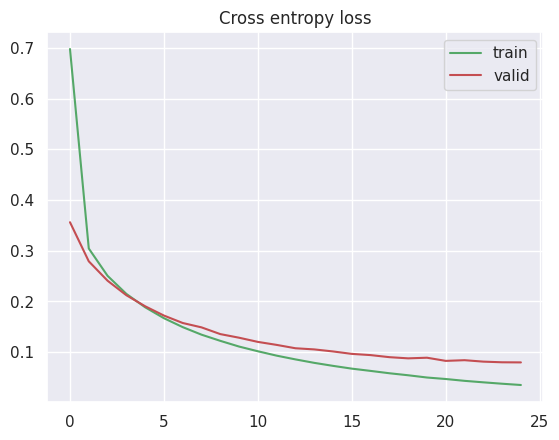

In [25]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

## Testando e avaliando o modelo

Loop de teste

In [26]:
all_probs = []
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0
classifier.eval()
for test_instances, instance_labels in test_dl:
    test_instances = test_instances.to(device)
    instance_labels = instance_labels.to(device)

    with torch.no_grad():
        logits = classifier(test_instances)
    probabilities = nn.functional.softmax(logits, 1)
    all_probs.append(probabilities.cpu())
    preds = torch.argmax(probabilities, 1)

    total_corrects += (preds == instance_labels).sum().item()
    total_n += len(test_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(instance_labels.unsqueeze(-1))


preds = torch.cat(all_preds).squeeze(-1).cpu()
targets = torch.cat(all_targets).squeeze(-1).cpu()

A matriz de confusão (quanto mais preenchida a diagonal principal, melhor)

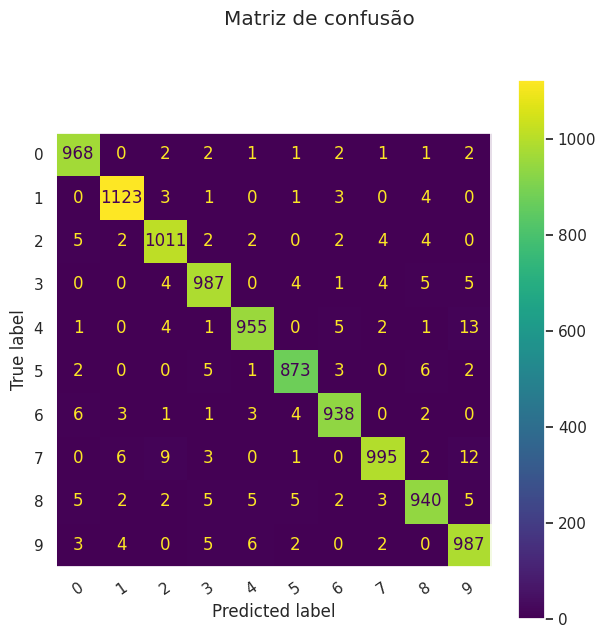

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
fig.suptitle("Matriz de confusão")
ax.grid(False)

labels = list(str(i) for i in range(10))

cm = confusion_matrix(targets, preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
cm_display.plot(ax=ax, xticks_rotation=35.0)

O `classification_report` do scikit-learn contém precisão, recall, escore F1 e acurácia

In [28]:
print(classification_report(targets, preds, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

